In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt, dates
from pandas.api.types import is_numeric_dtype

# **1.Ingestion**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path1 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_02_fuel_leak_signals_preprocessed.csv'
msn02 = pd.read_csv(file_path1, delimiter=';')

file_path2 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_10_fuel_leak_signals_preprocessed.csv'
msn10 = pd.read_csv(file_path2, delimiter=';')

file_path3 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_11_fuel_leak_signals_preprocessed.csv'
msn11 = pd.read_csv(file_path3, delimiter=';')

file_path4 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_12_fuel_leak_signals_preprocessed.csv'
msn12 = pd.read_csv(file_path4, delimiter=';')

file_path5 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_14_fuel_leak_signals_preprocessed.csv'
msn14 = pd.read_csv(file_path5, delimiter=';')

file_path6 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_29_fuel_leak_signals_preprocessed.csv'
msn29 = pd.read_csv(file_path6, delimiter=';')

file_path7 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_37_fuel_leak_signals_preprocessed.csv'
msn37 = pd.read_csv(file_path7, delimiter=';')

file_path8 = '/content/drive/MyDrive/Colab Notebooks/Capstone/msn_53_fuel_leak_signals_preprocessed.csv'
msn53 = pd.read_csv(file_path8, delimiter=';')

In [ ]:
datasets = [msn02, msn10, msn11, msn12, msn14, msn29, msn37, msn53]
dataset_labels = ['msn02', 'msn10', 'msn11', 'msn12', 'msn14', 'msn29', 'msn37', 'msn53']

In [ ]:
datasets_dict = dict(zip(dataset_labels, datasets))

# **2. Autoencoder Model**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
final_msn02_noleak =  pd.read_csv('final_msn02_noleak.csv')
final_msn02_leak_05 = pd.read_csv('final_msn02_leak_05.csv')

In [ ]:
final_msn37 = pd.read_csv('final_msn37.csv')
final_msn37_leak_05 = pd.read_csv('final_msn37_leak_05.csv')

In [ ]:
final_msn37['LEAK']=0
final_msn37_leak_05['LEAK']=1
final_msn37_testing = pd.concat([final_msn37, final_msn37_leak_05], ignore_index=True)

In [ ]:
final_msn37_testing.to_csv('final_msn37_testing.csv',  index = False)

In [ ]:
final_msn02_noleak['LEAK'] = 0

In [ ]:
final_msn02_leak_05['LEAK'] = 1

## **2.1. Feature Selection and Normalization**

We filter the data from msn02 according to the relevant features we found from the Exploratory Data Analysis

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
data = final_msn02_noleak
features_to_use = ['TOTAL_FUEL_USED_PERIOD', 'DELTA_TOTAL_FUEL_USED', 'CUMULATIVE_DELTA_TOTAL_FUEL_USED',
                   'PERCENTAGE_CHANGE_TOTAL_FUEL_USED', 'VALUE_FOB', 'DELTA_FOB', 'CUMULATIVE_DELTA_FOB',
                   'PERCENTAGE_CHANGE_FOB', 'EST_FOB', 'FOB_ERROR', 'FOB_POLY', 'FW_GEO_ALTITUDE', 'SECONDS_OF_FLIGHT', 'LEAK']
data_selected = data[features_to_use]
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_selected), columns=data_selected.columns)
print(data_normalized.head())

   TOTAL_FUEL_USED_PERIOD  DELTA_TOTAL_FUEL_USED  \
0                0.016155               0.499902   
1                0.016250               0.500510   
2                0.016344               0.500510   
3                0.016436               0.500492   
4                0.016524               0.500473   

   CUMULATIVE_DELTA_TOTAL_FUEL_USED  PERCENTAGE_CHANGE_TOTAL_FUEL_USED  \
0                          0.000000                           0.325913   
1                          0.000096                           0.328854   
2                          0.000191                           0.328842   
3                          0.000284                           0.328747   
4                          0.000374                           0.328650   

   VALUE_FOB  DELTA_FOB  CUMULATIVE_DELTA_FOB  PERCENTAGE_CHANGE_FOB  \
0   0.374454   0.854592              0.988263               0.858703   
1   0.374482   0.855442              0.988308               0.859375   
2   0.374225   0.846939   

## **2.2. Sequence Creation**

We create sequence of rows for each flight to match the required structure in order to train the model.

In [ ]:
import numpy as np
flights = data['Flight'].unique()
sequences = []
sequence_labels = []
sequence_length = 1800
for flight in flights:
    flight_data = data_normalized[data['Flight'] == flight]
    for start_idx in range(0, flight_data.shape[0] - sequence_length + 1, sequence_length):
        end_idx = start_idx + sequence_length
        sequence = flight_data.iloc[start_idx:end_idx].values
        sequences.append(sequence)
        sequence_labels.append(flight)
sequences_array = np.array(sequences)
sequence_labels = np.zeros(len(sequences))
print(f"Total sequences created: {len(sequences)}")
print(f"Shape of each sequence: {sequences_array.shape}")

Total sequences created: 196
Shape of each sequence: (196, 1800, 14)


## **2.3. Model Architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
n_features = data_normalized.shape[1]
n_features = len(features_to_use)
l2_reg = 0.001
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg), input_shape=(1800, n_features)),
    LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(l2_reg)),
    RepeatVector(1800),
    LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg)),
    LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(l2_reg)),
    TimeDistributed(Dense(n_features))
])
optimizer = Adam(lr=1e-5, clipnorm=0.5)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1800, 128)         73216     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVecto  (None, 1800, 64)          0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1800, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 1800, 128)         98816     
                                                                 
 time_distributed (TimeDist  (None, 1800, 14)          1806      
 ributed)                                               

## **2.4. Model Training**

The model was trained using a early stopping in case that the model's loss acquires a null value.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(sequences_array, sequences_array, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
6/6 [==============================] - 82s 14s/step - loss: 0.2376 - val_loss: 0.2283
Epoch 2/10
6/6 [==============================] - 84s 14s/step - loss: 0.2130 - val_loss: 0.2072
Epoch 3/10
6/6 [==============================] - 85s 15s/step - loss: 0.1917 - val_loss: 0.1869
Epoch 4/10
6/6 [==============================] - 80s 14s/step - loss: 0.1725 - val_loss: 0.1691
Epoch 5/10
6/6 [==============================] - 78s 13s/step - loss: 0.1552 - val_loss: 0.1513
Epoch 6/10
6/6 [==============================] - 76s 13s/step - loss: 0.1394 - val_loss: 0.1359
Epoch 7/10
6/6 [==============================] - 76s 13s/step - loss: 0.1253 - val_loss: 0.1206
Epoch 8/10
6/6 [==============================] - 82s 14s/step - loss: 0.1132 - val_loss: 0.1071
Epoch 9/10
6/6 [==============================] - 88s 15s/step - loss: 0.1025 - val_loss: 0.0988
Epoch 10/10
6/6 [==============================] - 83s 14s/step - loss: 0.0930 - val_loss: 0.0888


## **2.5. Anomaly detection**

Calculating the MSE value for the predicted array

In [ ]:
reconstructed_sequences = model.predict(sequences_array)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

7/7 [==============================] - 28s 3s/step


## **2.6. Evaluating the model with a new dataset (msn37 with and without leaks of 0.5 kg/s)**

In [ ]:
import numpy as np
new_data_normalized = scaler.transform(final_msn37_testing[features_to_use])
sequence_length = 1800
leak_threshold = sequence_length * 0.3
sequences_new = []
leak_labels_new = []
for i in range(0, len(new_data_normalized) - sequence_length + 1, sequence_length):
    sequence = new_data_normalized[i:i+sequence_length]
    sequences_new.append(sequence)
    leak_count = final_msn37_testing['LEAK'][i:i+sequence_length].sum()
    leak_sequence_label = int(leak_count >= leak_threshold)
    leak_labels_new.append(leak_sequence_label)
sequences_new = np.array(sequences_new)
leak_labels_new = np.array(leak_labels_new)

In [ ]:
reconstructed_sequences_new = model.predict(sequences_new)
mse_new = np.mean(np.power(sequences_new - reconstructed_sequences_new, 2), axis=(1, 2))
threshold_new = np.percentile(mse_new, 50)
predicted_anomalies_new = mse_new > threshold_new

3/3 [==============================] - 10s 3s/step


## **2.7. Classiication metrics and confussion matrix**

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        39
           1       0.82      0.82      0.82        39

    accuracy                           0.82        78
   macro avg       0.82      0.82      0.82        78
weighted avg       0.82      0.82      0.82        78



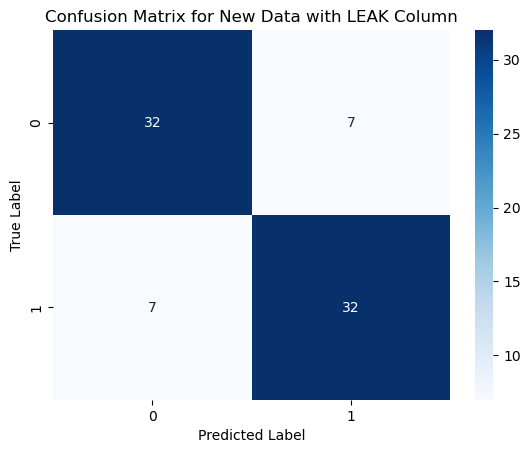

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predicted_labels_new = predicted_anomalies_new.astype(int)
print(classification_report(leak_labels_new, predicted_labels_new))
cm = confusion_matrix(leak_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for New Data with LEAK Column')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **2.8. MSE Distribution for Normal vs Anomalous Sequences**

C:\Users\fhuer\AppData\Local\Temp\ipykernel_320\2439516834.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mse_new[leak_labels_new == 0], bins=20, kde=True, label='Normal')
C:\Users\fhuer\AppData\Local\Temp\ipykernel_320\2439516834.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mse_new[

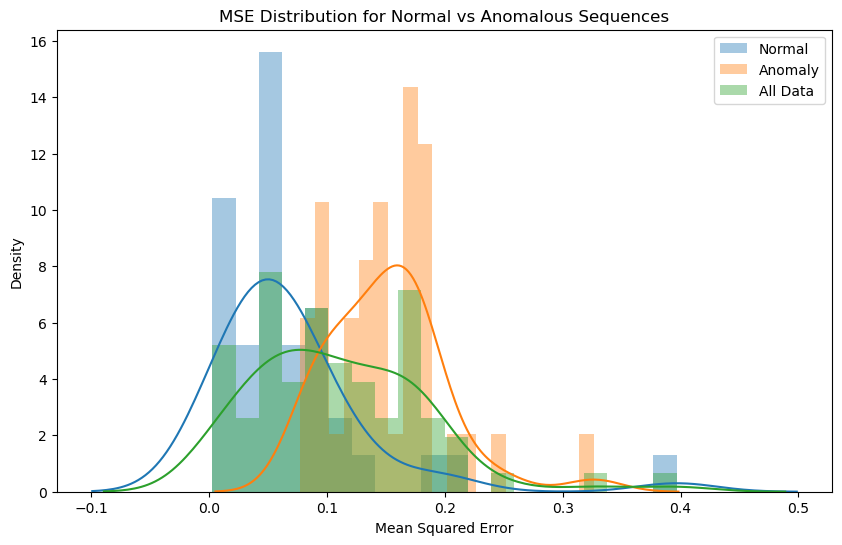

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(mse_new[leak_labels_new == 0], bins=20, kde=True, label='Normal')
sns.distplot(mse_new[leak_labels_new == 1], bins=20, kde=True, label='Anomaly')
sns.distplot(mse_new, bins=20, kde=True, label='All Data')
plt.xlabel('Mean Squared Error')
plt.ylabel('Density')
plt.title('MSE Distribution for Normal vs Anomalous Sequences')
plt.legend()
plt.show()